## This notebook demonstrate how to model a dwarf galaxy using [`the tractor`](https://github.com/dstndstn/tractor). 
- Need help when installing `the tractor`? Check [this website](https://astrojacobli.github.io/blog/2018/10/Macbook-for-Astronomy#install-the-tractor).
- You need to install [`kuaizi`](https://github.com/AstroJacobLi/kuaizi) to run this notebook. `kuaizi` contains some handy tools I often use.

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download DECaLS DR8 brick catalog

In [ ]:
!wget https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr8/survey-bricks.fits.gz

## Download DECaLS DR8 cutout images

In [3]:
download_decals_cutout(28.985515, -2.9498012, 60, 'r', layer='dr8', pixel_unit=False, output_name='Merian01')

Merian01_r.fits: 221kB [00:03, 61.7kB/s]                            

# Downloading Merian01_r.fits finished! 


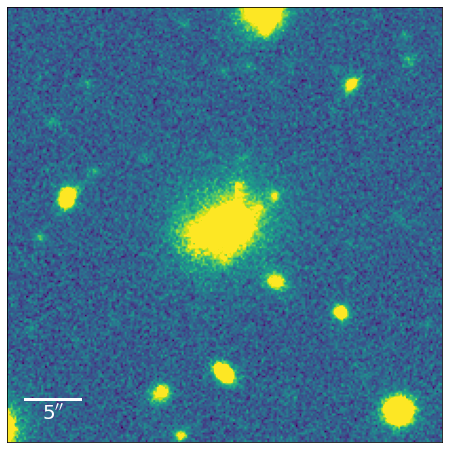

In [5]:
hdu = fits.open('./Merian01_r.fits')
img = hdu[0].data
w = wcs.WCS(hdu[0].header)
display_single(img);

# Detected 19 objects


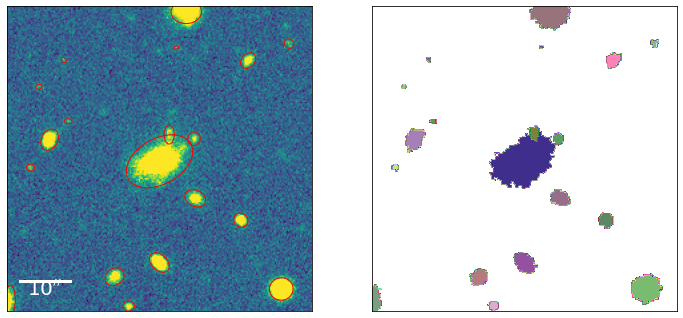

In [6]:
# Extract objects using SEP
from kuaizi.utils import extract_obj
obj_cat, segmap, _ = extract_obj(
    img,
    b=16,
    f=2,
    sigma=2,
    pixel_scale=DECaLS_pixel_scale,
    minarea=5,
    deblend_nthresh=32,
    deblend_cont=0.0005,
    sky_subtract=True, 
    show_fig=True)

In [7]:
# Generate manual measurement table
obj_table = obj_cat
pixel_scale = DECaLS_pixel_scale
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (
    pixel_scale * obj_table['b'])  # arcsec
x = obj_table['x']
y = obj_table['y']
ra, dec = w.wcs_pix2world(list(zip(x, y)), 1).T
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a']  # pixel
b = obj_table['b']  # pixel
theta = obj_table['theta']
flux = obj_table['flux']
index = obj_table['index']
fwhm = obj_table['fwhm_custom']
point_source = [((b_arcsec[i] / a_arcsec[i] > .9) and (a_arcsec[i] < .35))
                for i in range(len(obj_table))]
detection_cat = Table([
    index, ra, dec, x, y, x2, y2, xy, a, b, a_arcsec, b_arcsec, theta, flux,
    fwhm, point_source
],
                  names=('index', 'ra', 'dec', 'x', 'y', 'x2', 'y2', 'xy', 'a',
                         'b', 'a_arcsec', 'b_arcsec', 'theta', 'flux',
                         'fwhm_custom', 'point_source'),
                  meta={'name': 'object table'})

In [8]:
# Download DECaLS tractor catalogs and match SEP detection with the tractor catalog
from astropy.table import vstack
from astropy.coordinates import match_coordinates_sky
bricks_cat = Table.read('./survey-bricks.fits.gz', format='fits') # DR8 brick catalog
bricks_corr = SkyCoord(
    ra=np.array(bricks_cat['RA']) * u.degree,
    dec=np.array(bricks_cat['DEC']) * u.degree)
detect_coor = SkyCoord(ra=detection_cat['ra'] * u.degree, dec=detection_cat['dec'] * u.degree)
# Match our detection catalog to see which bricks it belongs to
to_download = bricks_cat[np.unique(
    match_coordinates_sky(detect_coor, bricks_corr)[0])]
bricknames = to_download['BRICKNAME'].data.astype(str) # in case that there are more than one `tractor` file

In [9]:
# Download tractor catalog of the corresponding brick
tractor_cat = kuaizi.download.download_decals_tractor_catalog(bricknames, layer='dr8', overwrite=True)

./tractor-0288m030.fits: 9.67MB [00:11, 848kB/s]                             


# Downloading ./tractor-0288m030.fits finished! 


In [17]:
# Match these galaxies with DECaLS tractor file and get their type
decals_corr = SkyCoord(
    ra=np.array(tractor_cat['ra']) * u.degree,
    dec=np.array(tractor_cat['dec']) * u.degree)

detect_coor = SkyCoord(ra=detection_cat['ra'] * u.degree, dec=detection_cat['dec'] * u.degree)

temp = tractor_cat[match_coordinates_sky(detect_coor, decals_corr)[0]]
for columns in temp.columns:
    detection_cat.add_column(temp[columns], rename_duplicate=True)
detection_cat.sort('flux', reverse=True)

from scipy import spatial
A = np.array(list(zip(detection_cat['x'], detection_cat['y'])))
cen_obj_indx = spatial.KDTree(A).query([int(img.shape[0]/2), int(img.shape[1]/2)])[1]
cen_obj = detection_cat[cen_obj_indx]

print(f'# Type of central object is {cen_obj["type"]}')
print(f'# Total number of objects: {len(detection_cat)}')

# Type of central object is EXP 
# Total number of objects: 19


In [18]:
from tractor import NCircularGaussianPSF
from kuaizi.tractor.utils import tractor_iteration, add_tractor_sources

# Construct PSF
psf_obj = NCircularGaussianPSF([tractor_cat['psfsize_r'].mean() / 2.355], [1])
# Mock invvar map
noisesigma = 0.003
invvar = np.ones_like(img) / noisesigma**2

Now you have 5 sources
Now you have 12 sources


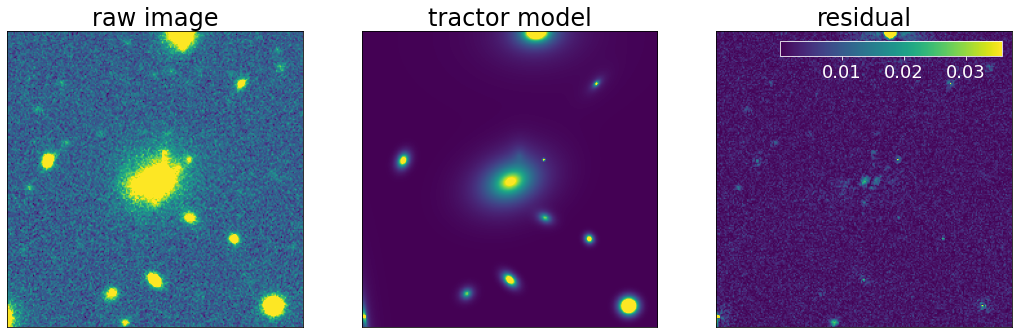

The chi-square is 3.4796583e-05
Now you have 19 sources


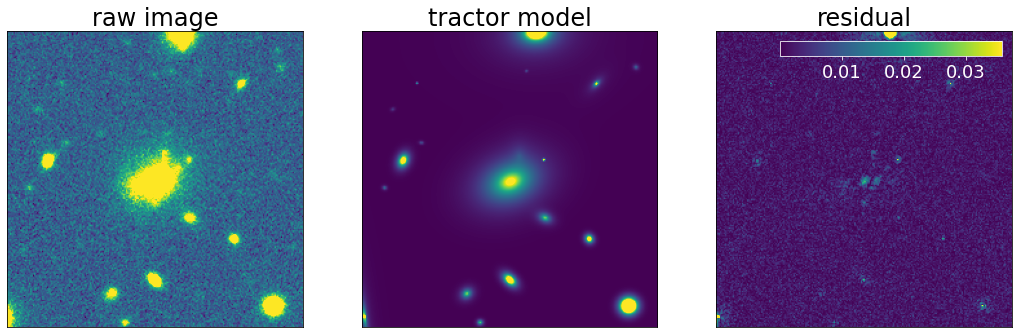

The chi-square is 0.00411519


In [19]:
# Fitting the galaxy iteratively. 
sources, trac_obj, fig = tractor_iteration(
    detection_cat,
    w,
    img,
    invvar,
    psf_obj,
    DECaLS_pixel_scale,
    shape_method='manual',
    freeze_pos=False,
    kfold=3,
    first_num=5,
    fig_name='Merian01')

# Properties of target galaxy:
  pos.x = 114.36
  pos.y = 111.97
  brightness.Flux = 54.35
  shape.re = 5.53
  shape.ab = 0.70
  shape.phi = 110.66


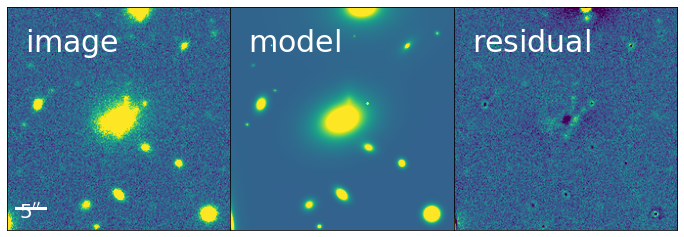

In [22]:
kuaizi.display.display_multiple(
    [img, trac_obj.getModelImage(0), img - trac_obj.getModelImage(0)],
    text=['image', 'model', 'residual'])
src = sources[cen_obj_indx]
print('# Properties of target galaxy:')
for i in range(len(src.getAllParams())):
    print(f'  {src.getParamNames()[i]} = {src.getAllParams()[i]:.2f}')

### The second example is a much simpler one, we try to fit it with 1) exponential, 2) Sersic model.

In [23]:
download_decals_cutout(139.6888462, 0.4005861, 60, 'r', layer='dr8', pixel_unit=False, output_name='Merian02')

Merian02_r.fits: 221kB [00:02, 81.6kB/s]                            


# Downloading Merian02_r.fits finished! 


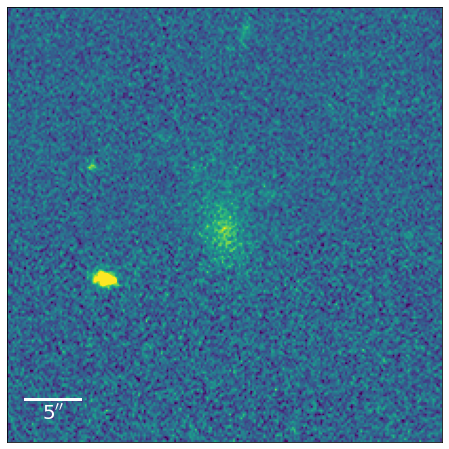

In [24]:
hdu = fits.open('./Merian02_r.fits')
img = hdu[0].data
w = wcs.WCS(hdu[0].header)
display_single(img);

# Detected 4 objects


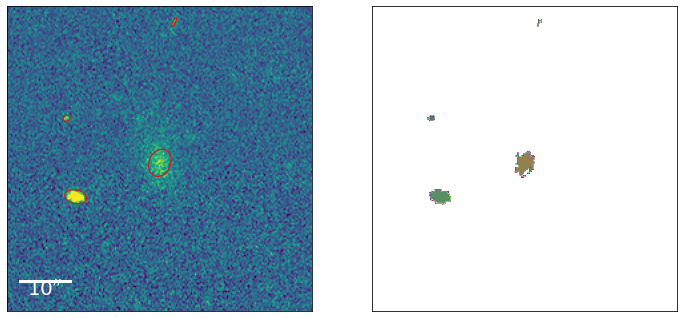

In [25]:
# Extract objects using SEP
from kuaizi.utils import extract_obj
obj_cat, segmap, _ = extract_obj(
    img, # i-band
    b=128,
    f=2,
    sigma=2,
    pixel_scale=DECaLS_pixel_scale,
    minarea=5,
    deblend_nthresh=32,
    deblend_cont=0.0005,
    sky_subtract=True, 
    show_fig=True)

In [26]:
from astropy import wcs
obj_table = obj_cat

# Generate manual measurement table
pixel_scale = DECaLS_pixel_scale
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (
    pixel_scale * obj_table['b'])  # arcsec
x = obj_table['x']
y = obj_table['y']
ra, dec = w.wcs_pix2world(list(zip(x, y)), 1).T
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a']  # pixel
b = obj_table['b']  # pixel
theta = obj_table['theta']
flux = obj_table['flux']
index = obj_table['index']
fwhm = obj_table['fwhm_custom']
point_source = [((b_arcsec[i] / a_arcsec[i] > .9) and (a_arcsec[i] < .35))
                for i in range(len(obj_table))]
detection_cat = Table([
    index, ra, dec, x, y, x2, y2, xy, a, b, a_arcsec, b_arcsec, theta, flux,
    fwhm, point_source
],
                  names=('index', 'ra', 'dec', 'x', 'y', 'x2', 'y2', 'xy', 'a',
                         'b', 'a_arcsec', 'b_arcsec', 'theta', 'flux',
                         'fwhm_custom', 'point_source'),
                  meta={'name': 'object table'})

In [27]:
# Download DECaLS tractor catalogs
from astropy.table import vstack
from astropy.coordinates import match_coordinates_sky
bricks_cat = Table.read('./survey-bricks.fits.gz', format='fits') # DR8 brick catalog
bricks_corr = SkyCoord(
    ra=np.array(bricks_cat['RA']) * u.degree,
    dec=np.array(bricks_cat['DEC']) * u.degree)
detect_coor = SkyCoord(ra=detection_cat['ra'] * u.degree, dec=detection_cat['dec'] * u.degree)
# Match our detection catalog to see which bricks it belongs to
to_download = bricks_cat[np.unique(
    match_coordinates_sky(detect_coor, bricks_corr)[0])]
bricknames = to_download['BRICKNAME'].data.astype(str) # in case that there are more than one `tractor` file

In [28]:
# Download tractor catalog of the corresponding brick
tractor_cat = kuaizi.download.download_decals_tractor_catalog(bricknames, layer='dr8', overwrite=True)

./tractor-1396p005.fits: 7.19MB [00:07, 918kB/s]                             


# Downloading ./tractor-1396p005.fits finished! 


In [30]:
# Match these galaxies with DECaLS tractor file and get their type
decals_corr = SkyCoord(
    ra=np.array(tractor_cat['ra']) * u.degree,
    dec=np.array(tractor_cat['dec']) * u.degree)

detect_coor = SkyCoord(ra=detection_cat['ra'] * u.degree, dec=detection_cat['dec'] * u.degree)

temp = tractor_cat[match_coordinates_sky(detect_coor, decals_corr)[0]]
for columns in temp.columns:
    detection_cat.add_column(temp[columns], rename_duplicate=True)
detection_cat.sort('flux', reverse=True)

from scipy import spatial
A = np.array(list(zip(detection_cat['x'], detection_cat['y'])))
cen_obj_indx = spatial.KDTree(A).query([int(img.shape[0]/2), int(img.shape[1]/2)])[1]
cen_obj = detection_cat[cen_obj_indx]

print(f'# Type of central object is {cen_obj["type"]}')
print(f'# Total number of objects: {len(detection_cat)}')

# Type of central object is EXP 
# Total number of objects: 4


In [31]:
from tractor.psf import NCircularGaussianPSF
from kuaizi.tractor.utils import tractor_iteration, add_tractor_sources

# Construct PSF
psf_obj = NCircularGaussianPSF([tractor_cat['psfsize_r'].mean() / 2.355], [1])
# Mock invvar map
noisesigma = 0.003
invvar = np.ones_like(img) / noisesigma**2

Now you have 1 sources
Now you have 2 sources


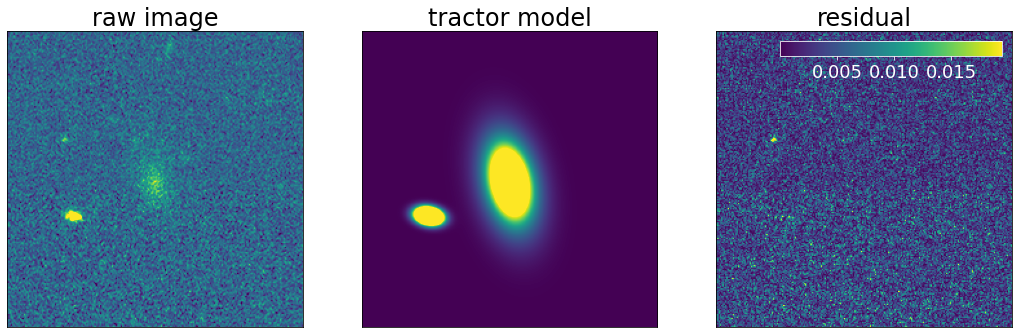

The chi-square is 0.0002929723
Now you have 3 sources


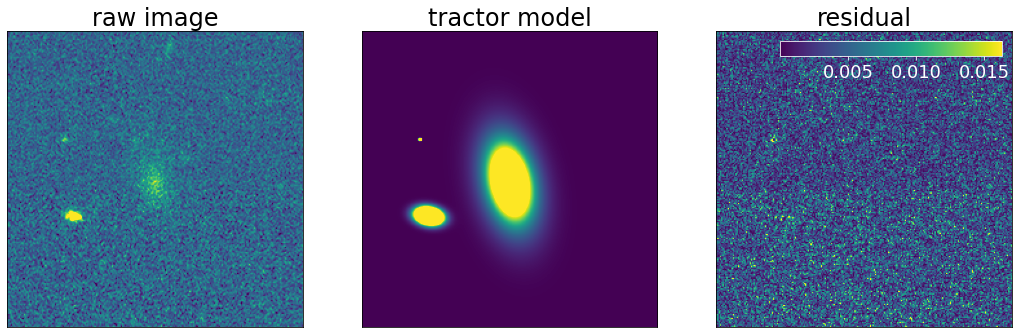

The chi-square is 0.005186757


In [33]:
sources, trac_obj, fig = tractor_iteration(
    detection_cat,
    w,
    img,
    invvar,
    psf_obj,
    DECaLS_pixel_scale,
    shape_method='manual',
    freeze_pos=False,
    kfold=3,
    first_num=1,
    fig_name='Merian02')

# Properties of target galaxy:
  pos.x = 113.91
  pos.y = 111.35
  brightness.Flux = 15.02
  shape.re = 5.83
  shape.ab = 0.55
  shape.phi = 191.77


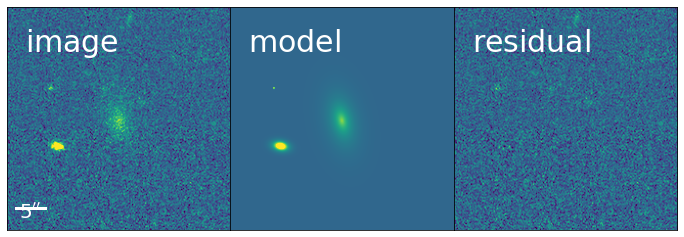

In [34]:
kuaizi.display.display_multiple(
    [img, trac_obj.getModelImage(0), img - trac_obj.getModelImage(0)],
    text=['image', 'model', 'residual'])
src = sources[cen_obj_indx]
print('# Properties of target galaxy:')
for i in range(len(src.getAllParams())):
    print(f'  {src.getParamNames()[i]} = {src.getAllParams()[i]:.2f}')

### Now fit the target galaxy with signle Sersic

In [36]:
# Set the type of target object to Sersic 
detection_cat[cen_obj_indx]['type'] = 'SER'

# Replace the PSF one with EXP, to get a better fitting
for i in np.argwhere(detection_cat['type'] == 'PSF '):
    detection_cat[int(i[0])]['type'] = 'EXP'

Now you have 1 sources
Now you have 2 sources


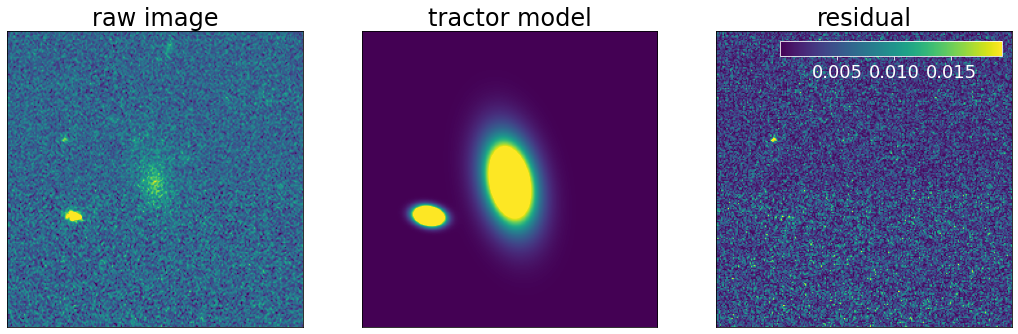

The chi-square is 0.00029297193
Now you have 3 sources


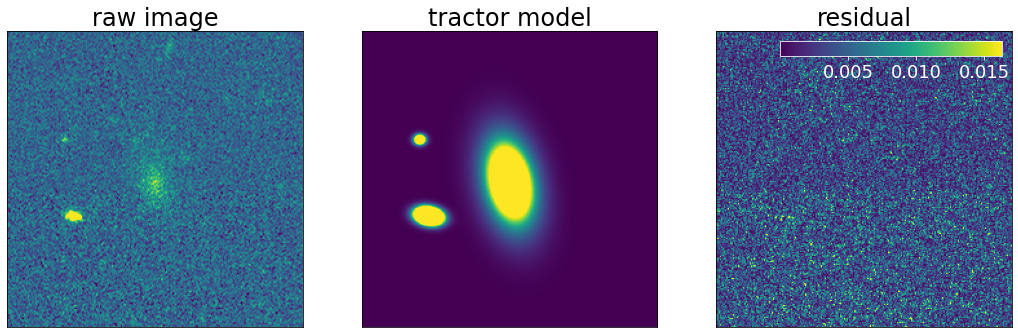

The chi-square is 0.005180784


In [37]:
sources, trac_obj, fig = tractor_iteration(
    detection_cat,
    w,
    img,
    invvar,
    psf_obj,
    DECaLS_pixel_scale,
    shape_method='manual',
    freeze_pos=False,
    kfold=3,
    first_num=1,
    fig_name='test')

# Properties of target galaxy:
  pos.x = 113.90
  pos.y = 111.36
  brightness.Flux = 14.88
  shape.re = 5.74
  shape.ab = 0.55
  shape.phi = 191.80
  sersicindex.SersicIndex = 0.96


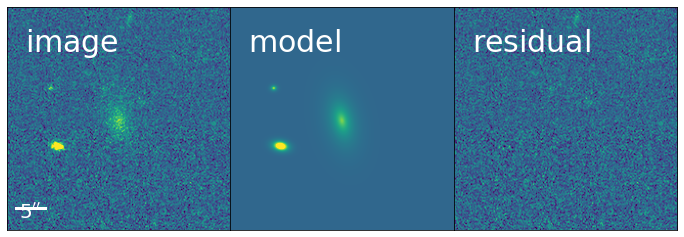

In [38]:
kuaizi.display.display_multiple(
    [img, trac_obj.getModelImage(0), img - trac_obj.getModelImage(0)],
    text=['image', 'model', 'residual'])
src = sources[cen_obj_indx]
print('# Properties of target galaxy:')
for i in range(len(src.getAllParams())):
    print(f'  {src.getParamNames()[i]} = {src.getAllParams()[i]:.2f}')